In [ ]:
#Importing the required libraries. 
import pandas as pd
import numpy as np
import os
import string
import re

# importing the nltk suite 
import nltk
import spacy
  
# python -m spacy download en_core_web_sm

from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, auc
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.multilabel_confusion_matrix.html
# f1 

#Importing visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns


!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#To get curse words list collated by Google. 
import urllib.request

#To get the multi-label classifiers
!pip install scikit-multilearn


import gensim.downloader as api
model_glove_twitter = api.load("glove-twitter-25")

#NLTK
import nltk




In [ ]:
# # from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
#Data-folder path. 
from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/My Drive/Colab Notebooks/CSC791 NATURAL LANGUAGE PROCESSING

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Colab Notebooks/CSC791 NATURAL LANGUAGE PROCESSING


In [ ]:
#Reading in the train and test datasets. 
all_train = pd.read_csv("jigsaw-toxic-comment-classification-challenge/train.csv/train.csv")

In [ ]:
#Reducing size of the data:
all_train['Label_Exists'] = all_train.iloc[:,2:].sum(axis=1)
train_with_labels = all_train[all_train['Label_Exists'] >= 1]
train_without_labels = all_train[all_train['Label_Exists'] == 0]

#Sampling
train_with_labels_sample = train_with_labels.sample(n = 10000, replace=False, random_state=42)
train_without_labels_sample = train_without_labels.sample(n = 10000, replace=False, random_state=42)
train = pd.DataFrame()
train = pd.concat([train_with_labels_sample,train_without_labels_sample])
train.drop(['Label_Exists'],axis = 1,inplace = True)

## <font color = 'Violet'> Data Cleaning and Pre-processing </font>

Data has following features which will make modeling difficult. Just by examining top 50 rows we can establish that the following need to be removed - 
<font color = 'Turquoise'>
1. \n characters
2. Image: should be removed
3. IP addresses, http links
4. Wiki links
5. Date related fields
6. Unnecessary punctuations

</font>

Once the preliminary cleaning is done, we need to do some spelling corrections since the language is informal has been observed to have some mistakes

<font color = 'Lightblue'> Note: The following tasks have NOT BEEN perfomed for reasons stated below- 
1. Stop words have NOT been removed, because we are using a context-based embedding technique which relies on stop words to build proper context. 
2. Words have NOT been converted to lower-case because we believe that some places, where capital words have been used, reflect emphasis that the speaker want to convey. 
 </font>


#### <font color = 'Orange'> Text Cleaning </font>

In [ ]:
def text_cleaning(sentence):

    #Removing \n characters
    sentence = re.sub('\n', ' ', sentence)
    
    #Remove hyperlinks, www sites and IP address
    sentence = re.sub('www\.\S+','',sentence)
    sentence = re.sub('http?://\S+','',sentence)
    sentence = re.sub('\d+.\d+.\d+.\d+','',sentence) #IP address 
    
    #Date and time removal (UTC):
    sentence = re.sub('\d+:\d+:\d+','',sentence)
    sentence = re.sub('[A-Za-z]+ \d+, (\d+ \(UTC\))','',sentence)
    
    #Removing unncessary punctuations
    sentence.translate(str.maketrans('', '', re.escape(string.punctuation)))
    sentence = re.sub('[%s]' % re.escape(string.punctuation), '', sentence)
    
    #Removing characters enclosed in brackets:
    sentence = re.sub('<*?>+|\[.*?\]', '', sentence)

    #Alphanumeric 
    sentence = re.sub('\w*\d\w*', '', sentence)
    
    #Words starting with image and ending with jpg
    sentence = re.sub('Image.*?jpg', '', sentence)

    return sentence

#### <font color = 'Orange'> Spelling Correction </font>

In [ ]:
"""Spelling Corrector in Python 3; see http://norvig.com/spell-correct.html

Copyright (c) 2007-2016 Peter Norvig
MIT license: www.opensource.org/licenses/mit-license.php
"""

################ Spelling Corrector 

import re
from collections import Counter

def words(text): return re.findall(r'\w+', text.lower())

#Spelling correction has been performed by considering the customer support tweets as a reference. 
WORDS = Counter(words(open('big.txt').read()))

def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return WORDS[word] / N

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))


def spell_correction(text):
  # print ("sentence:--->"+text)
  result= ""
  W= text.split()
  for word in W:
    result += correction(word) + " "

  # sptext =  ' '.join([spell.correction(w).lower() if spell.unknown(w) else w for w in text])
  print ("after spell check:"+ result)
  return result

In [ ]:
train['clean_text'] = train['comment_text'].apply(str).apply(lambda x: text_cleaning(x))
# train['spell_check'] = train['clean_text'].apply(str).apply(lambda x: spell_correction(x))


In [ ]:
train_for_distilBERT = train.copy()

## <font color = 'Violet'> Exploratory Data Analysis </font>
In this section the following tasks have been covered, to get an understanding of the data - 
<font color = 'Turquoise'>
1. Label-wise proportion of toxic comment instances in training data. 
2. Correlation scores between different labels, given that we have a multi-label classification task. 
3. Determining the sentiment score of sentences, and checking if there is a correlation between the polarity of sentiment and the labels. 

</font>

#### <font color = 'Orange'> Label distribution plots </font>

In [ ]:
print(train.shape)
train.head()

(20000, 9)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_text
45045,786d8ca9b0bad3cc,"""\nI was talking about them running any check ...",1,0,0,0,0,0,I was talking about them running any check th...
27198,47f18388952e3ee7,White Trash\nFuck off you white piece of trash...,1,1,1,0,1,1,White Trash Fuck off you white piece of trash ...
16664,2bf361b9a8eb1ba5,eat shit get rid of goofs you queers.,1,0,1,0,1,0,eat shit get rid of goofs you queers
8158,15b6fd032e614001,DUMB ASSES\nIt's was my sockpuppet...joe hazet...,1,0,0,0,0,0,DUMB ASSES Its was my sockpuppetjoe hazeton yo...
142212,f8b05b9ae771fb50,"Are all professors of rhetoric pompous, self-c...",1,0,1,0,1,0,Are all professors of rhetoric pompous selfcen...


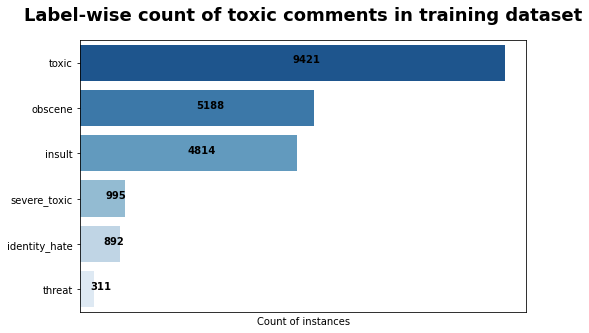

In [ ]:
#Count of labels:
label_counts = pd.DataFrame(train.iloc[:,2:8].apply(lambda x: x.sum(),axis = 0)).sort_values(0,ascending = False).reset_index().rename(columns = {'index':'label',0:'counts'})

#Bar-plot
palette = sns.color_palette("Blues")
palette.reverse()
fig, ax = plt.subplots(figsize = (8,5))
sns.barplot(x = label_counts.counts,
            y = label_counts.label,
            data = label_counts,palette = palette)

ax.set_title("Label-wise count of toxic comments in training dataset", weight = 'bold', fontsize = 18, y = 1.05 )
ax.set_xlabel('Count of instances')
ax.set_ylabel('')
ax.set_xticks([])

for index, row in label_counts.iterrows():
  ax.text(row.counts/2 + 300, row.name,round(row.counts,2), color='black', ha="center",fontsize = 10,weight = 'bold')

plt.show()

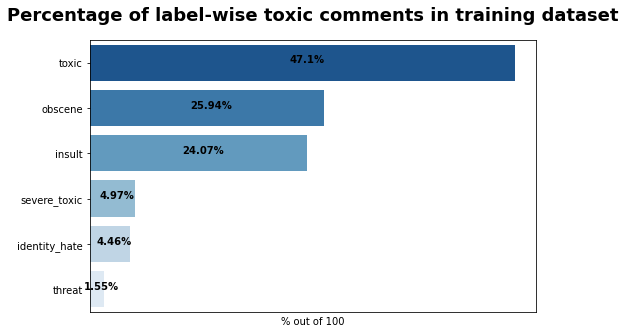

In [ ]:
#Proportion of 1s in each column
label_proportions = pd.DataFrame(train.iloc[:,2:8].apply(lambda x: x.sum() * 100/len(x),axis = 0)).sort_values(0,ascending = False).reset_index().rename(columns = {'index':'label',0:'proportions'})

#Bar-plot
palette = sns.color_palette("Blues")
palette.reverse()
fig, ax = plt.subplots(figsize = (8,5))
sns.barplot(x = label_proportions.proportions,
            y = label_proportions.label,
            data = label_proportions,palette = palette)

ax.set_title("Percentage of label-wise toxic comments in training dataset", weight = 'bold', fontsize = 18, y = 1.05 )
ax.set_xlabel('% out of 100')
ax.set_ylabel('')
ax.set_xticks([])

for index, row in label_proportions.iterrows():
  ax.text(row.proportions/2 + 0.5, row.name,str(round(row.proportions,2)) + str('%'), color='black', ha="center",fontsize = 10,weight = 'bold')

plt.show()

In [ ]:
print("Nulls in train data")
print(train.isna().sum())

Nulls in train data
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
clean_text       0
dtype: int64


Text(0.5, 1.0, 'Correlation between different labels')

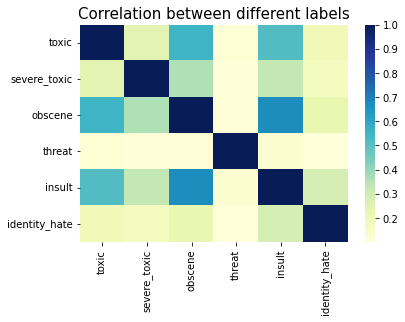

In [ ]:
sns.heatmap(train.corr(),cmap="YlGnBu")
plt.title('Correlation between different labels',fontsize = 15)

<font color = 'Lightgreen'> 
We observe strong positive correlations between the following pairs of labels- 
1. Insult and Toxic
2. Obscene and Toxic
3. Obscene and Insult

It is very likely that all three are occuring together for certain toxic comments. 
</font> 

#### <font color = 'Orange'> Sentiment Analysis</font>

In [ ]:
analyser = SentimentIntensityAnalyzer()
train['sentiment_score'] = train['clean_text'].apply(lambda x:analyser.polarity_scores(x)['compound'] )

In [ ]:
#Generating a dataset which has label-wise sentiment scores for plotting. 
label_sentiments = pd.DataFrame()
for label in train.columns[2:8].values:
  single_label_data = pd.DataFrame(train[train[label] == 1]['sentiment_score']).reset_index(drop = True)
  single_label_data['label'] = label
  label_sentiments = label_sentiments.append(single_label_data)

Text(0.5, 0, '')

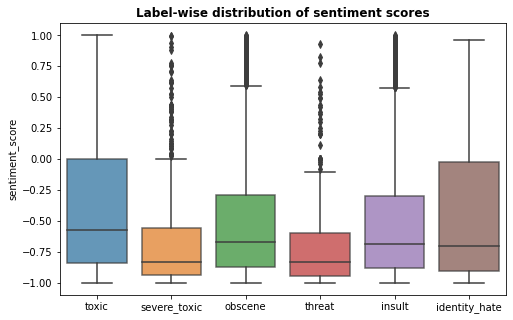

In [ ]:
#Plotting
fig, ax = plt.subplots(figsize = (8,5))
ax = sns.boxplot(x="label", y="sentiment_score", data=label_sentiments,boxprops=dict(alpha=.75))
ax.set_title("Label-wise distribution of sentiment scores",weight = 'bold',fontsize = 12)
ax.set_xlabel('')

Text(0.5, 0, '')

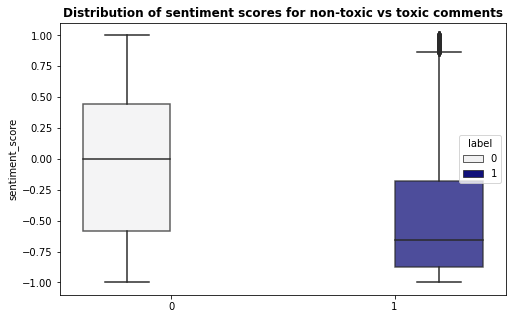

In [ ]:
#Transformation of train_data for sentiment analysis
sentiment_label_table = pd.DataFrame()
for label in label_counts.label.values:
  subset_df = train[[label,'sentiment_score']].copy()
  subset_df.rename(columns = {label:'label'},inplace=True)
  sentiment_label_table = sentiment_label_table.append(subset_df)
  sentiment_label_table.reset_index()

#Plotting
fig, ax = plt.subplots(figsize = (8,5))
ax = sns.boxplot(x="label", y="sentiment_score", data=sentiment_label_table, color = 'Darkblue',boxprops=dict(alpha=.75),hue = 'label')
ax.set_title("Distribution of sentiment scores for non-toxic vs toxic comments",weight = 'bold',fontsize = 12)
ax.set_xlabel('')

<Figure size 432x288 with 0 Axes>

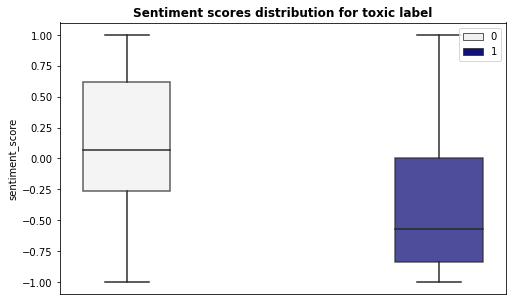

<Figure size 432x288 with 0 Axes>

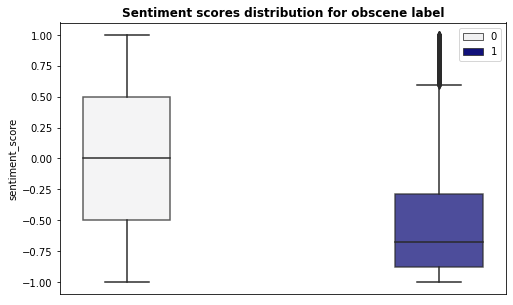

<Figure size 432x288 with 0 Axes>

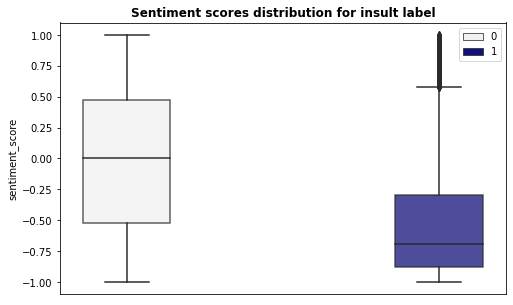

<Figure size 432x288 with 0 Axes>

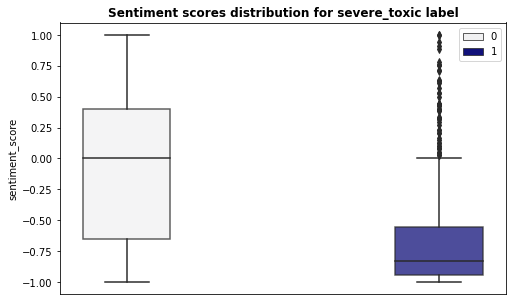

<Figure size 432x288 with 0 Axes>

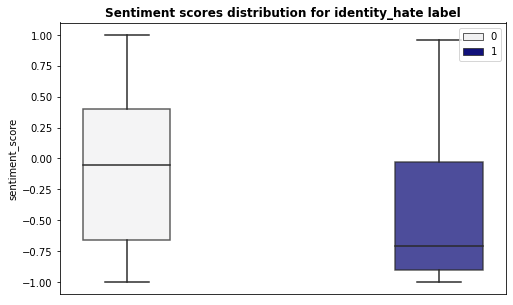

<Figure size 432x288 with 0 Axes>

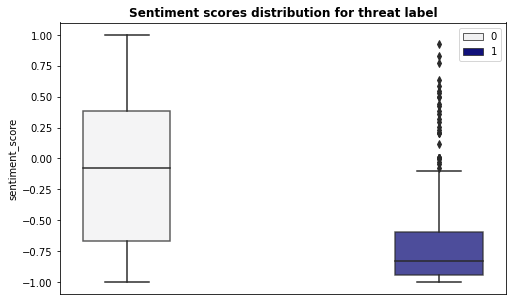

In [ ]:
for label in label_counts.label.values:
  plt.clf()
  fig, ax = plt.subplots(figsize = (8,5))
  ax = sns.boxplot(x=label, y="sentiment_score", data=train, color = 'Darkblue',boxprops=dict(alpha=.75),hue = label)
  ax.set_title("Sentiment scores distribution for " + label + " label",weight = 'bold',fontsize = 12)
  ax.set_xlabel('')
  ax.set_xticks([])
  plt.legend(loc='upper right')
  plt.show()


<font color = 'Lightgreen'> 
1. We can clearly see that the sentences which are labeled as non-toxic have a comparitively positive sentiment (0 or more), in comparison to those which take on at-least one of the six labels. 
Such sentences have an average negative sentiment polarity of -0.75.
2. Hence we can conclude that sentences with toxic labels are indeed full of negative sentiments. 

</font>

#### <font color = 'Orange'>  Curse Words Analysis </font>

In [ ]:
cursewords = [re.sub(r'^b|\\n|\'', '',str(line)) for line in urllib.request.urlopen('https://raw.githubusercontent.com/RobertJGabriel/Google-profanity-words/master/list.txt')]

In [ ]:
def count_curses(tokens):
  count_val = 0
  tokens = list(set(tokens))
  for word in tokens:
    if word.lower() in cursewords:
        count_val +=1
  return count_val

In [ ]:
def remove_white_space(sentence):
  good_list = [word for word in sentence.split() if word is not '']
  good_list  = ' '.join(good_list)
  return good_list

In [ ]:
#Doing a bit of text cleaning:
split_sent_df_train = pd.DataFrame()
split_sent_df_train['clean_text_no_whites'] = train['clean_text'].apply(lambda x: remove_white_space(x))
split_sent_df_train['tokenized'] = split_sent_df_train['clean_text_no_whites'].apply(lambda sentence: re.split(r'[.,"!()\'?]+|\s|\n', sentence))

In [ ]:
split_sent_df_train

,clean_text_no_whites,tokenized
45045,I was talking about them running any check the...,"[I, was, talking, about, them, running, any, c..."
27198,White Trash Fuck off you white piece of trash ...,"[White, Trash, Fuck, off, you, white, piece, o..."
16664,eat shit get rid of goofs you queers,"[eat, shit, get, rid, of, goofs, you, queers]"
8158,DUMB ASSES Its was my sockpuppetjoe hazeton yo...,"[DUMB, ASSES, Its, was, my, sockpuppetjoe, haz..."
142212,Are all professors of rhetoric pompous selfcen...,"[Are, all, professors, of, rhetoric, pompous, ..."
...,...,...
158222,Because you read it in the Splinter Cell wiki ...,"[Because, you, read, it, in, the, Splinter, Ce..."
141632,Do you have a source other than your opinion f...,"[Do, you, have, a, source, other, than, your, ..."
130875,REDIRECT TalkRiver Rescue video game,"[REDIRECT, TalkRiver, Rescue, video, game]"
94411,I do not blame you I was basically gang raped ...,"[I, do, not, blame, you, I, was, basically, ga..."


In [ ]:
train['curse_word_count'] = split_sent_df_train['tokenized'].apply(lambda x: count_curses(x))

In [ ]:
#Creating a dataset which has labels, and corresponding curse word count and sentiment score for that label.
label_curse_words = pd.DataFrame()
for label in train.columns[2:8].values:
  single_label_data = pd.DataFrame(train[train[label] == 1][['curse_word_count','sentiment_score']]).reset_index(drop = True)
  single_label_data['label'] = label
  label_curse_words = label_curse_words.append(single_label_data)

In [ ]:
# #For every label, find the mean sentiment score and proportion of curse words...
label_curse_words_grouped = label_curse_words.groupby(['label']).agg({'curse_word_count':'mean','sentiment_score':'mean'}).reset_index()
label_curse_words_grouped['curse_word_count'] = label_curse_words_grouped['curse_word_count'] #*100

Text(0, 0.5, 'Mean number of curse words in a sentence')

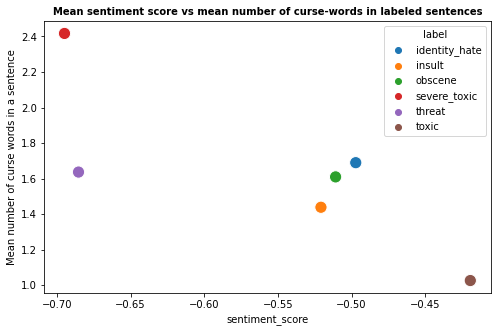

In [ ]:
fig, ax = plt.subplots(figsize = (8,5))
sns.scatterplot(x = 'sentiment_score' , y =  'curse_word_count', data = label_curse_words_grouped, hue = 'label',s = 150).set_title("Mean sentiment score vs mean number of curse-words in labeled sentences", fontsize = 10, weight = 'bold')
ax.set_ylabel('Mean number of curse words in a sentence')

<font color = 'lightgreen'> The below scatter plot tells us how proportion of the sentences belonging to one of the 6 categories have curse words. 

The way to interpret below graph is:
1. Look at the sentiment score - Our hypothesis is higher the negative polarity, higher the probability that the sentence has curse word. 
2. Pay attention to the labels as well. Some labels such as severe toxic have a very high probability of having curse words, but the other categories like toxic or threat have a lower chance of containing a curse word in their sentences


</font>


Text(0.5, 1.0, 'Count of curse-words in each sentence')

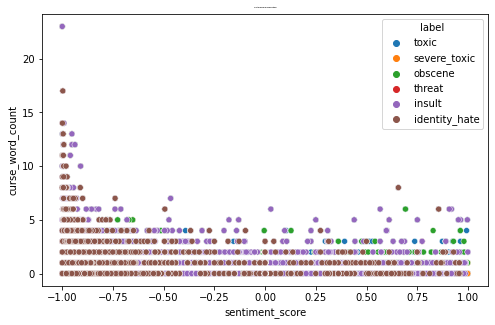

In [ ]:
#Plotting
fig, ax = plt.subplots(figsize = (8,5))
sns.scatterplot(x = 'sentiment_score' , y =  'curse_word_count', data = label_curse_words, hue = 'label') #,s = 150
ax.set_title("Count of curse-words in each sentence", fontsize = 1, weight = 'bold')
# ax.set_ylabel('Percentage of instances with curse words')

#### <font color = 'Orange'> Profanity with positive sentiment </font>

Text(0.5, 1.0, 'Count of curse-words vs sentiment score for non-toxic text')

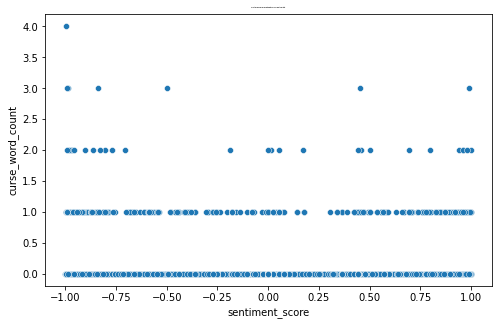

In [ ]:
train['non-toxic'] = train.iloc[:,2:8].sum(axis = 1)
non_toxic_text = train[train['non-toxic'] == 0].copy()
non_toxic_text.head()

fig, ax = plt.subplots(figsize = (8,5))
sns.scatterplot(x = 'sentiment_score' , y =  'curse_word_count', data = non_toxic_text) #,s = 150
ax.set_title("Count of curse-words vs sentiment score for non-toxic text", fontsize = 1, weight = 'bold')


In [ ]:
# !pip install nltk

# !pip install spacy==2.3.5

# !pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.3.1/en_core_web_sm-2.3.1.tar.gz


## <font color = 'Violet'> TRADITIONAL MODEL </font>

We used context-independent classification model based on traditional techniques such as NLTK word tokenizer and GloVe word embeddings as our baseline approach.  For multi-label classification task, we used OneVsRest classifier and classifier Chain. 

GloVe is an unsupervised learning algorithm for obtaining vector representations for words. The GloVe model is trained over the non zero values of the global word-word co-occurrence matrix. Building this matrix needs one time walk through the entire corpus to collect the statistics. For big datasets, this can be expensive task, thus we used pre-trained model to perform the embeddings.

OneVsRest classifier divides the multi label classification problem into multiple independent binary classification problems. Where as classifier chain links together all binary classifiers in a chain structure, such that class label predictions from previous steps is used as features for the next classification step.

###<font color = 'Rainbow'> **Wordcloud** </font>

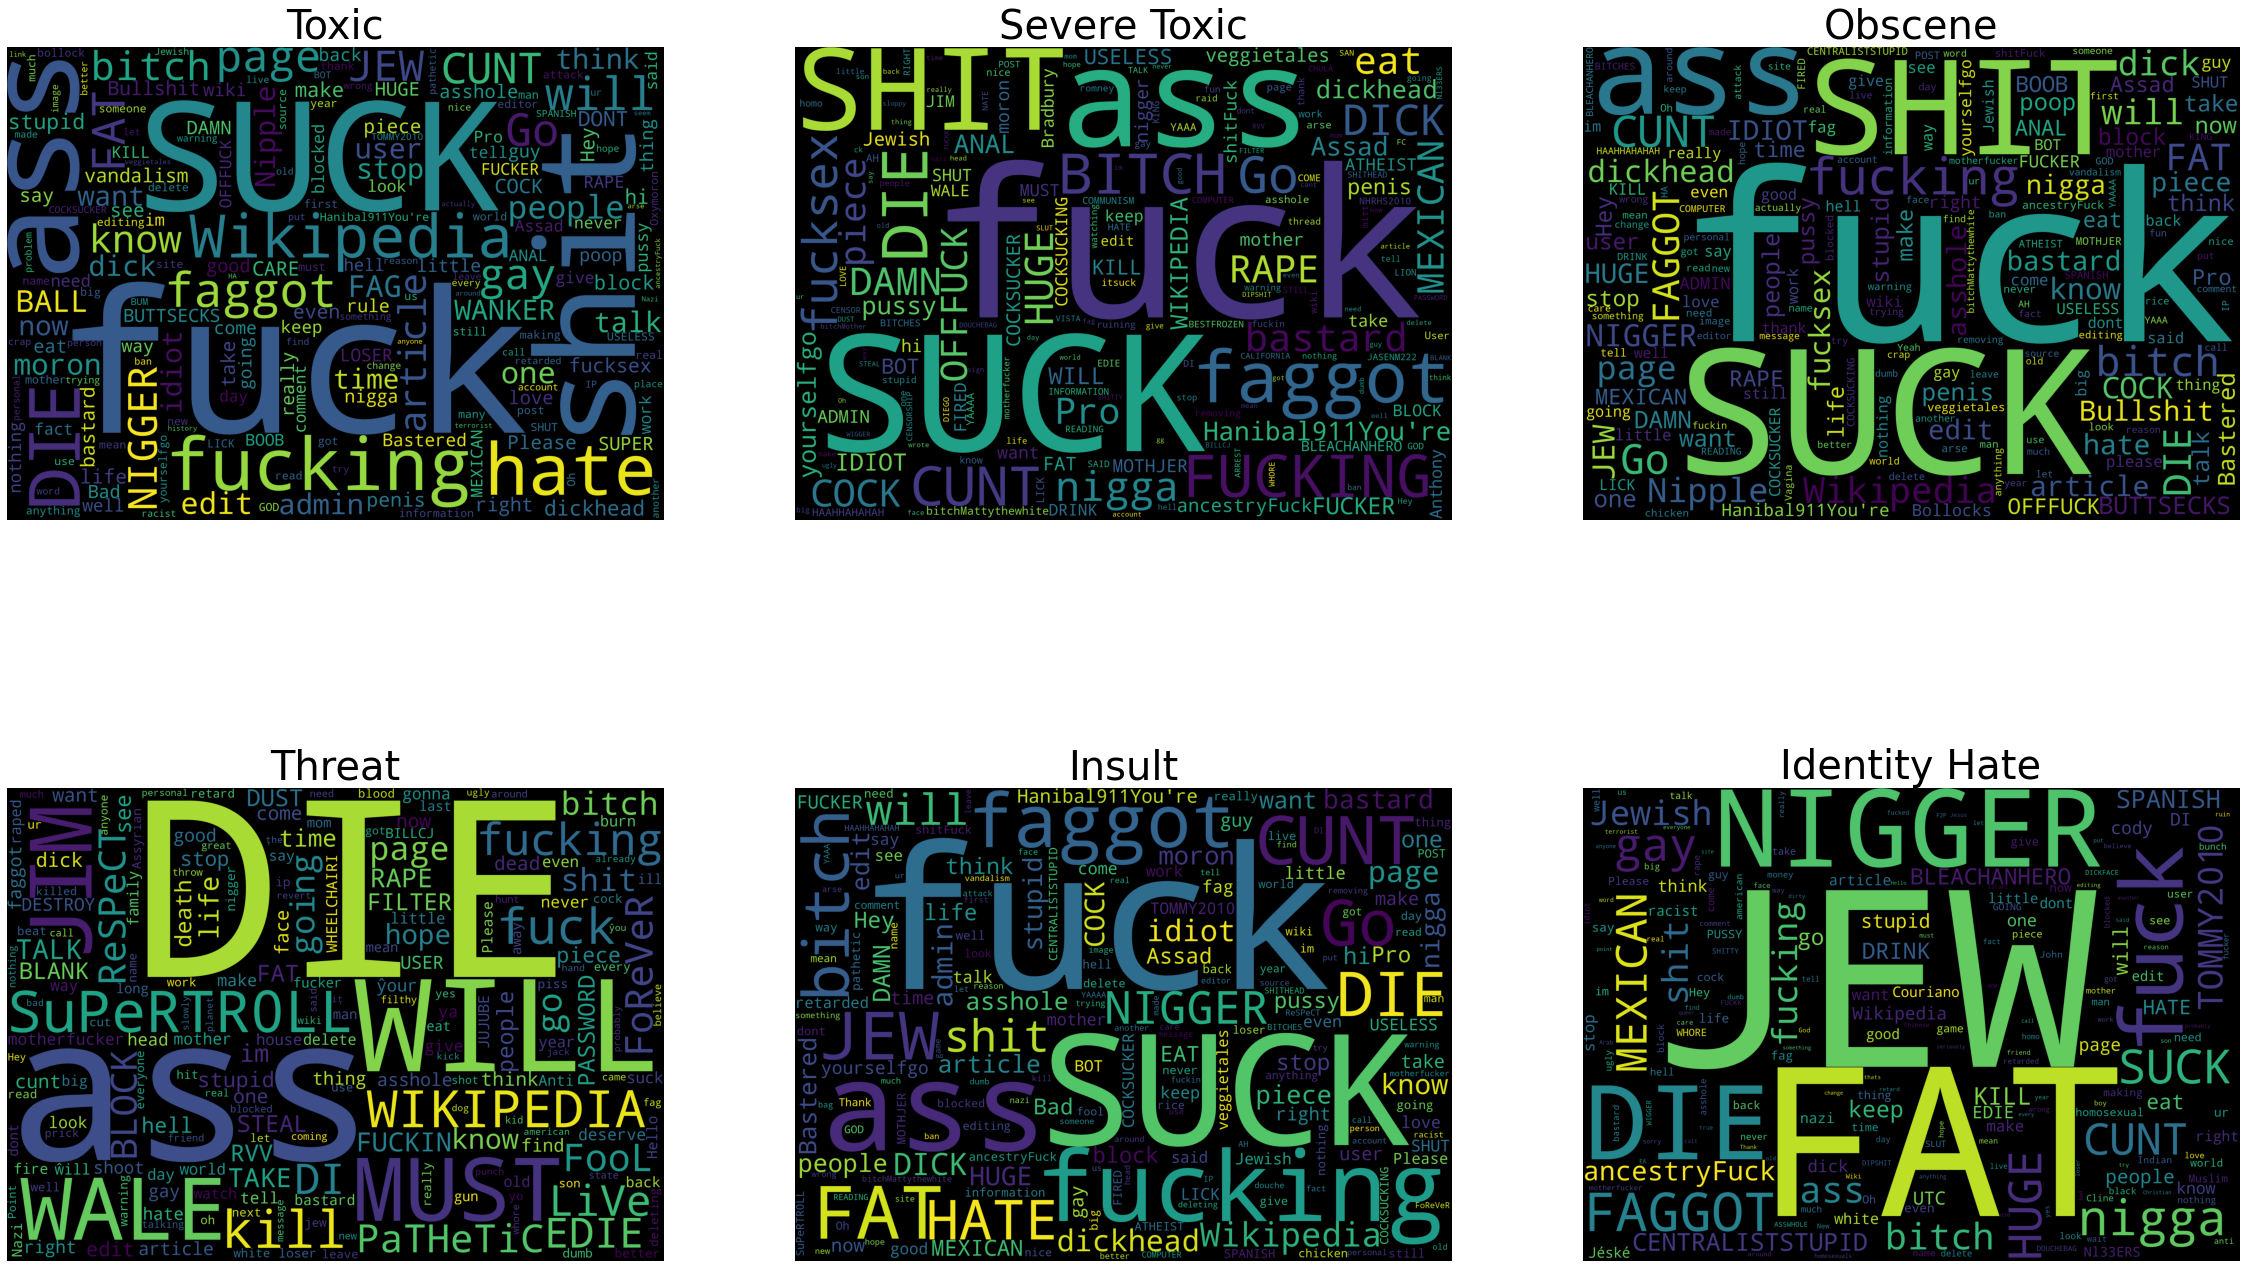

In [ ]:
from wordcloud import WordCloud,STOPWORDS

plt.figure(figsize=(40,25))

# toxic
subset = train[train.toxic==1]
text = subset.comment_text.values
cloud_toxic = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))

plt.subplot(2, 3, 1)
plt.axis('off')
plt.title("Toxic",fontsize=40)
plt.imshow(cloud_toxic)


# severe_toxic
subset = train[train.severe_toxic==1]
text = subset.comment_text.values
cloud_severe_toxic = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))

plt.subplot(2, 3, 2)
plt.axis('off')
plt.title("Severe Toxic",fontsize=40)
plt.imshow(cloud_severe_toxic)


# obscene
subset = train[train.obscene==1]
text = subset.comment_text.values
cloud_obscene = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))

plt.subplot(2, 3, 3)
plt.axis('off')
plt.title("Obscene",fontsize=40)
plt.imshow(cloud_obscene)


# threat
subset = train[train.threat==1]
text = subset.comment_text.values
cloud_threat = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))

plt.subplot(2, 3, 4)
plt.axis('off')
plt.title("Threat",fontsize=40)
plt.imshow(cloud_threat)


# insult
subset = train[train.insult==1]
text = subset.comment_text.values
cloud_insult = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))

plt.subplot(2, 3, 5)
plt.axis('off')
plt.title("Insult",fontsize=40)
plt.imshow(cloud_insult)


# identity_hate
subset = train[train.identity_hate==1]
text = subset.comment_text.values
cloud_identity_hate = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))

plt.subplot(2, 3, 6)
plt.axis('off')
plt.title("Identity Hate",fontsize=40)
plt.imshow(cloud_identity_hate)

plt.show()

###<font color = 'Rainbow'> **NLTK Word Tokenizer** </font>

We used NLTK's word\_tokenizer method to split a sentence into word tokens. NLTK (Natural Language ToolKit) is a library written in Python for symbolic and statistical Natural Language Processing. We noticed that this word tokenizer considers punctuation as tokens which might create trouble while performing the word embeddings. Thus we cleaned the text before feeding it to the tokenizer. 

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
stopword = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
train['clean_text_tokenized'] = train['clean_text'].apply(lambda x: nltk.word_tokenize(x))

###<font color = 'Rainbow'> **Stop Word Removal** </font>

In a contextual sentence, stopwords usually present an important role in formulating the meaning of the text. But In this context-independent model, we do not consider context of the sentences during the embeddings. Thus, stop words do not hold any meaning in the context-free approach. We used NLTK's stop word list to remove stop words from the dataset and we extended this list to contain other stopwords seen in our dataset, for example "wikipedia", "link", "page" etc. 

In [ ]:
import nltk
from nltk.corpus import stopwords
stopword = stopwords.words('english')
newStopWords = ['Wikipedia','wikipedia', 'article','link']
stopword.extend(newStopWords)

In [ ]:
def stopword_remove(word_tokens):
  removing_stopwords = [word for word in word_tokens if word not in stopword]
  return removing_stopwords

In [ ]:
train['clean_text_tokenized'] = train['clean_text_tokenized'].apply(lambda x: stopword_remove(x))


###<font color = 'Rainbow'> **Word Embedding: Glove Pretrained** </font>

We used GloVe to vectorize our sentences. The underline of the Glove model is that ratios of word-word co-occurrence probabilities have the potential for encoding some form of meaning.

In [ ]:
missing = 0
hit= 0 
data = []
import re
for tk in train['clean_text_tokenized']:
  arraylist = []
  if not tk:
    arraylist.append(np.zeros(25,dtype="float32"))
  for word in tk:
    hit = hit + 1
    try:
        arraylist.append(model_glove_twitter[word])
        
    except KeyError:
        missing += 1
        arraylist.append(np.zeros(25,dtype="float32"))
    
  array = np.mean(arraylist, axis=0)
  
  data.append(array,)

In [ ]:
df_t= pd.DataFrame(data)
df_t.reset_index()
train = train.reset_index()
train_df = train.join(df_t)

from sklearn.model_selection import train_test_split

train_gl, test_gl = train_test_split(train_df, random_state=1, test_size=0.10, shuffle=True)
X_train_gl = train_gl.iloc[:, -25:]
X_test_gl = test_gl.iloc[:, -25:]

In [ ]:
categories =  ['toxic',	'severe_toxic',	'obscene',	'threat',	'insult',	'identity_hate']

In [ ]:
train_gl.head(10)

,index,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_text,sentiment_score,curse_word_count,non-toxic,clean_text_tokenized,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
1810,147725,40d6431e631e36ac,"That may be the case, but there is still no am...",0,0,0,1,0,0,That may be the case but there is still no amb...,-0.8674,0,1,"[That, may, case, still, ambiguity, repulsiven...",-0.150553,0.033288,-0.014085,-0.319807,-0.183777,-0.210379,0.778308,-0.529013,0.066445,-0.185372,0.057442,0.166909,-2.529567,0.441293,0.207074,0.026229,0.356168,-0.067071,0.146735,-0.296077,-0.025973,0.581431,0.026140,-0.172504,-0.274143
18145,87280,e985354ca9a3f9b2,"""|benefits]]. If you edit without a username, ...",0,0,0,0,0,0,benefits If you edit without a username your I...,0.9947,0,0,"[benefits, If, edit, without, username, IP, ad...",0.098869,0.306494,-0.040842,-0.027205,0.109242,-0.253257,0.602986,-0.433648,-0.029929,-0.046863,-0.094367,0.217985,-2.208822,-0.116311,0.081715,0.216414,0.248829,-0.212583,-0.019914,-0.270718,-0.052207,-0.215361,-0.096060,0.036694,-0.476380
2377,132205,c379a0e8a853f889,Go Fuck Yourself \nStop sending me harrassing ...,1,0,1,0,1,0,Go Fuck Yourself Stop sending me harrassing m...,-0.6908,1,3,"[Go, Fuck, Yourself, Stop, sending, harrassing...",0.020521,0.266582,0.261451,0.053222,-0.030366,-0.253818,0.513628,-0.565741,-0.421532,-0.049011,-0.018380,0.205354,-1.976650,-0.138690,-0.021531,0.400148,0.173252,-0.166681,0.027914,-0.273294,0.068542,-0.118435,-0.053891,-0.038247,-0.427476
13417,144231,0a17e29614e3d63a,""")\nWould support an intro including """"Macedon...",0,0,0,0,0,0,Would support an intro including Macedonian S...,0.4019,0,0,"[Would, support, intro, including, Macedonian,...",0.182111,0.268470,-0.265970,0.021821,0.159704,-0.255209,0.212735,-0.373318,0.019540,-0.141015,0.025370,0.342342,-1.671298,0.040075,0.147342,-0.048199,0.188542,0.098561,0.104851,-0.154024,-0.143900,-0.293156,-0.253426,0.087351,-0.385630
7401,77435,cf75d2f46afe7585,Edit war\n\nI understand fully your a europhil...,0,0,1,0,1,1,Edit war I understand fully your a europhile ...,0.4475,1,3,"[Edit, war, I, understand, fully, europhile, b...",0.065715,0.356658,-0.191564,-0.162091,0.023563,-0.160014,0.678086,-0.314369,-0.046191,-0.054376,-0.151263,0.364830,-2.477896,0.059736,-0.024070,0.083397,0.097674,-0.135588,0.082948,-0.217744,0.084250,0.194561,-0.124002,-0.137758,-0.256101
5696,134305,ce26cedc315e5d96,"Objectivism \n\nHey Walter, dont you remember ...",1,0,1,0,1,1,Objectivism Hey Walter dont you remember me ...,0.0000,0,4,"[Objectivism, Hey, Walter, dont, remember, I, ...",0.091138,0.170730,-0.080281,0.050882,-0.073240,-0.039420,0.457090,-0.166847,-0.137778,-0.002396,-0.201133,0.087182,-1.521004,-0.096188,-0.039348,0.209645,0.076892,-0.160341,0.056668,-0.204195,0.264564,0.162142,-0.002676,-0.063045,-0.184822
14602,39054,68343458c2ad68d2,Except that wasn't always a redirect page. It ...,0,0,0,0,0,0,Except that wasnt always a redirect page It wa...,-0.5106,0,0,"[Except, wasnt, always, redirect, page, It, in...",0.035390,0.291421,-0.074221,0.014636,0.180586,-0.203276,0.627617,-0.838058,0.127390,-0.179176,-0.237854,0.531909,-2.658992,-0.071171,0.086627,0.350334,0.228237,-0.062451,0.284942,-0.445237,-0.070419,-0.273228,-0.025807,0.035221,-0.679676
7182,42502,716afff6ba7ef3fd,Bongfag \n\nyou are a lazy loser fucking stone...,1,0,1,0,1,0,Bongfag you are a lazy loser fucking stoner ...,-0.8665,2,3,"[Bongfag, lazy, loser, fucking, stoner, asshol...",-0.090176,0.360584,0.134403,-0.182930,0.278591,0.198108,1.039444,-0.529962,-0.500867,-0.046955,-0.457935,0.462630,-3.304618,-0.455005,0.300397,0.521755,0.451626,-0.425051,0.029797,-0.161994,0.246129,0.436999,0.136855,-0.128478,-0.187004
14991,39402,692749664bb35870,"And one of the sources is Israeli, if you have...",0,0,0,0,0,0,And one of the sources is Israeli if you have ...,0.0000,0,0,"[And, one, sources, Israeli, remarked]",0.348316,0.189446,0.176200,-0.001291,-

###<font color = 'Rainbow'> **Logistic Regression OneVsRest** </font>

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
LogReg_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)),
            ])

def onevsrest(category):
    #print('Processing {} comments...'.format(category))    
    model = LogReg_pipeline.fit(X_train_gl, train_gl[category])
    return model 


Test accuracy is 0.817


Test accuracy is 0.9515


Test accuracy is 0.806


Test accuracy is 0.9845


Test accuracy is 0.811


Test accuracy is 0.956




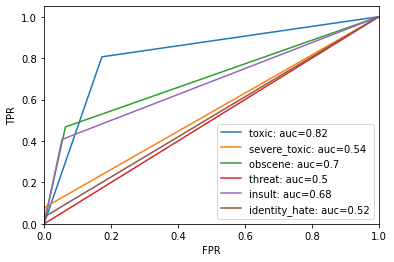

In [ ]:
from sklearn.metrics import RocCurveDisplay
import sklearn.metrics as metrics
accuracies= []
for category in categories:
  model = onevsrest(category)
  prediction = model.predict(X_test_gl)
  sc = accuracy_score(test_gl[category], prediction)
  accuracies.append(sc)
  print('Test accuracy is {}'.format(sc))
  print("\n")
  fpr, tpr, thresh = metrics.roc_curve(test_gl[category], prediction)
  auc = metrics.roc_auc_score(test_gl[category], prediction)
  auc= '{0:.2g}'.format(auc)
  plt.plot(fpr,tpr,label=str(category)+": auc="+str(auc)) 
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.legend(loc=0)
  plt.xlabel("FPR")
  plt.ylabel("TPR")

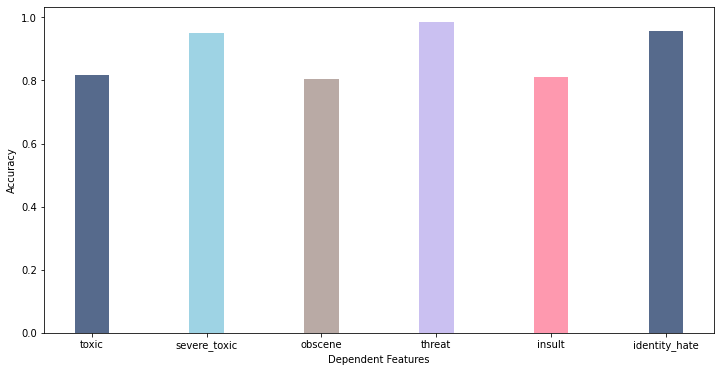

In [ ]:
rgb1 = np.random.rand(4,)
rgb2 = np.random.rand(4,)
rgb3 = np.random.rand(4,)
rgb4 = np.random.rand(4,)
rgb5 = np.random.rand(4,)
plt.bar(categories,accuracies,color=[rgb1,rgb2,rgb3,rgb4,rgb5], width=0.3)
plt.gcf().set_size_inches(12,6)
plt.tick_params(labelsize=10)
plt.xlabel('Dependent Features')
plt.ylabel('Accuracy')
plt.show()

###<font color = 'Rainbow'> **Classifier Chain** </font>

In [ ]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression

classifier = ClassifierChain(LogisticRegression())
classifier.fit(X_train_gl, train_gl[categories])
predictions = classifier.predict(X_test_gl)

# accuracy
print("Accuracy = ",accuracy_score(test_gl[categories],predictions))
print("\n")

Accuracy =  0.5705




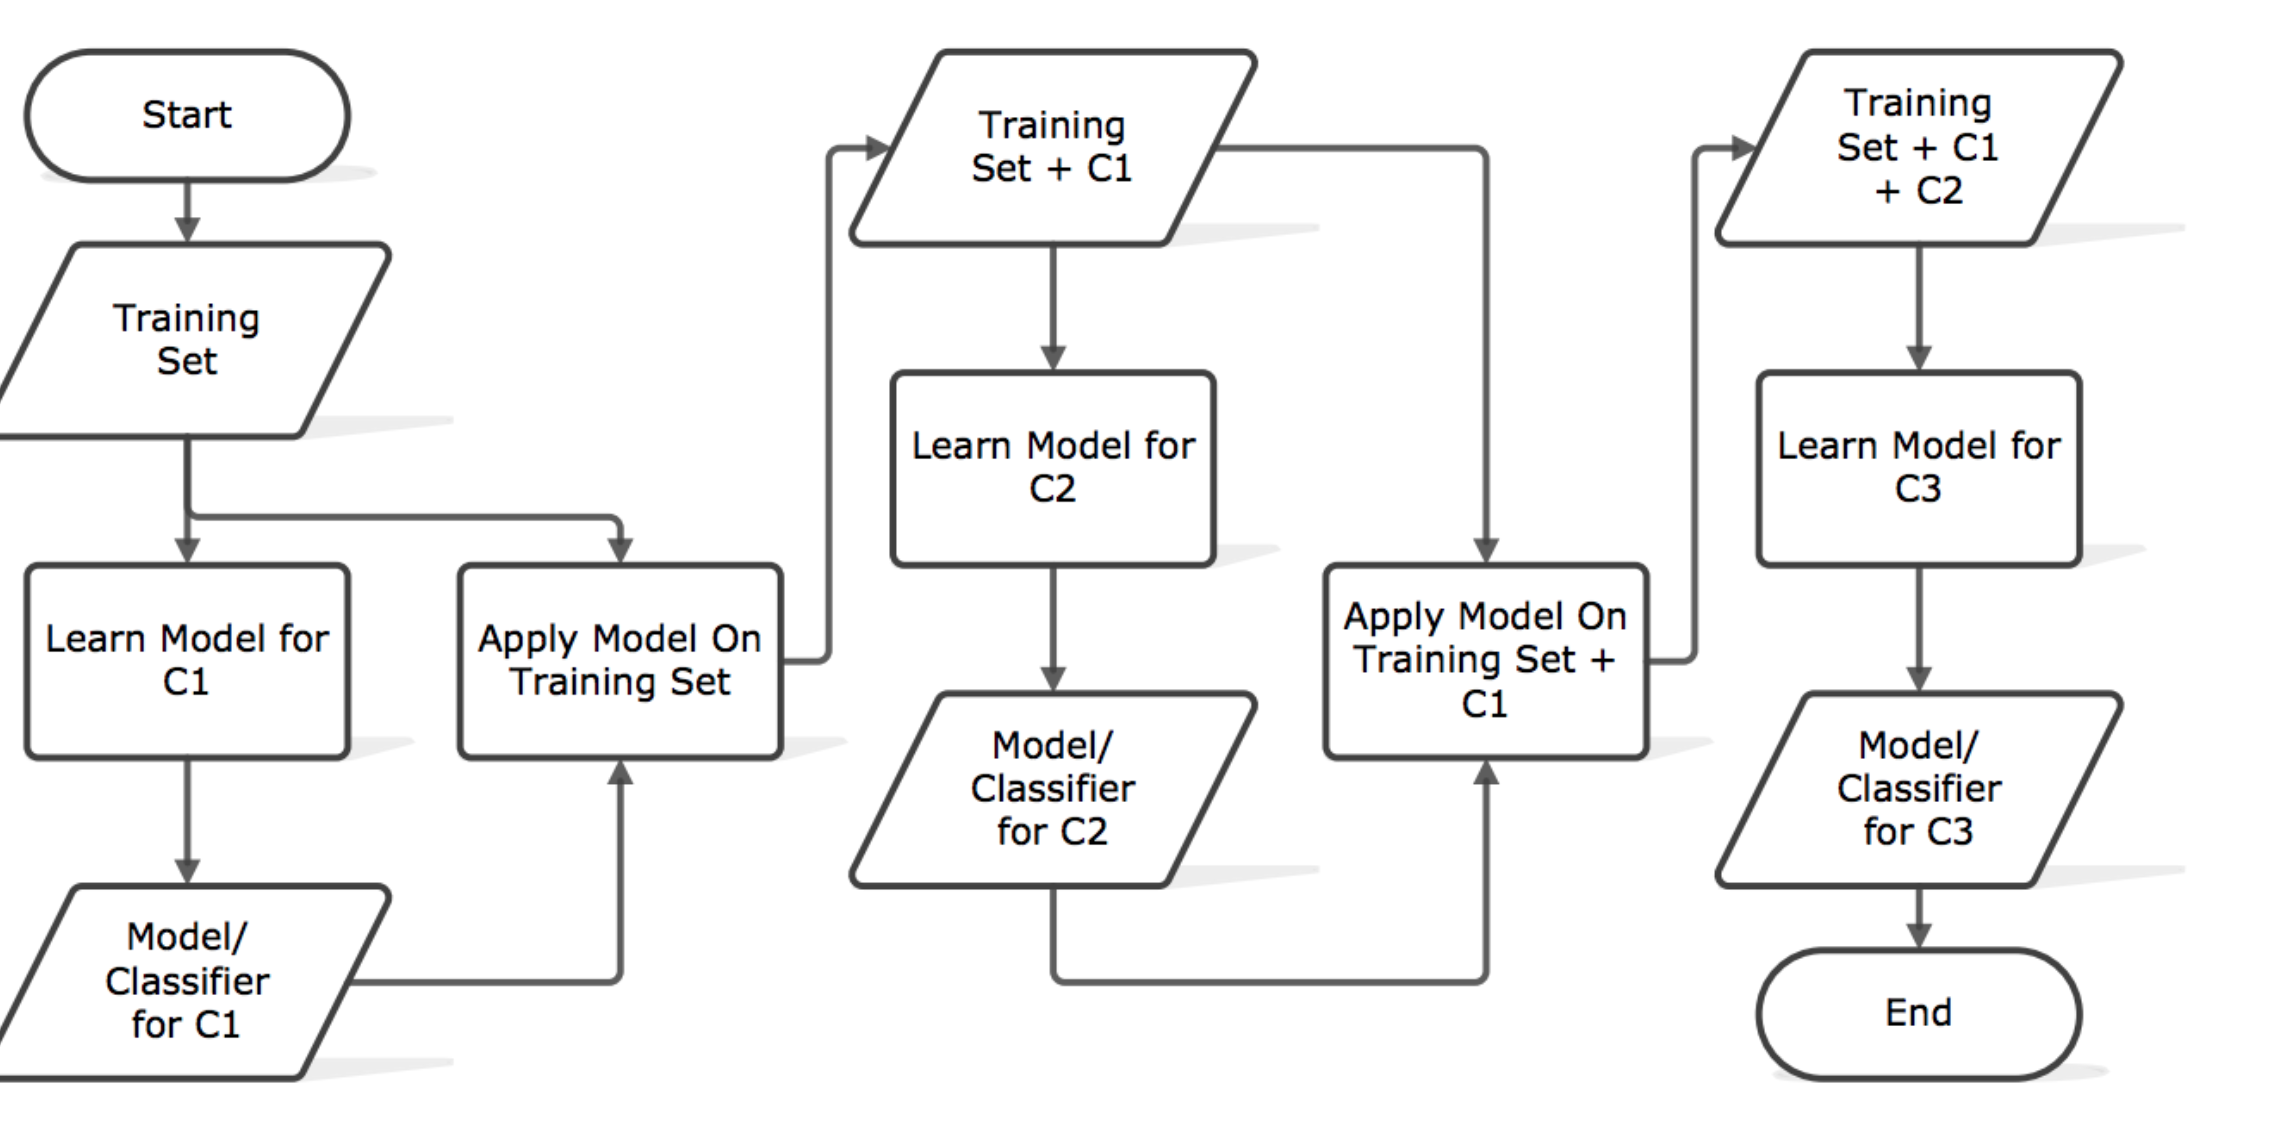

## <font color = 'Violet'> CONTEXT BASED MODEL </font>

To build our context based model, we are implementing a BERT based model with soft-max classification that supports multi-label classification. 


<font color = 'Turquoise'> 
1. Tokenizer: The default tokenizer used by distilBERT models is WordPiece, which we can load from pre-trained distilBERT tokenizers of transformer's class. We use the tokenizer specially designed for distilBERT-base-cased.
2. The second part contains building the actual model, which has the following two components: 
<font color = 'DarkTurquoise'> 
- Sentence-embedding: Our text-data consists of capital as well as small letters, and hence we proceed with distilbert-base-cased model. We go with distilBERT because it is one of the faster pre-trained models which only slightly affects model performance. 
- Multi-label classification model: Once the sentence embeddings are generated by distilBERT model, we create a Keras based classification model with following layers: 
- (a) Dropout layer of 0.1 for better generalizability of the model
- (b) Dense layer with 128 nodes
- (c) Dense layer with 32 nodes
- (d) Final dense output layer with 6 nodes that uses sigmoid classifier since we seek multi-label classification
</font>
</font>

<font color = 'Orange'> Some additional design decisions- 
1. Huggingface's pretrained models are used for tokenization and sentence embedding. The layers are made untrainable for sentence embeddings (so fine-tuning of weights is not allowed).
2. Adam optimizer, a standard choice, but AMSGrad is set to false. Traditionally, AMSGrad is an extension to the Adam version of gradient descent that attempts to improve the convergence properties of the algorithm, avoiding large abrupt changes in the learning rate for each input variable.
But due to a small learning rate of 5e-5, we set the AMSGrad to false since abrupt changes are very unlikely to happen. 
3. Loss function - BinaryCrossEntropy loss and evaluation metric is accuracy. 

</font>

Maybe build some kind of a validation dataset, perhaps?? --- Plotting between training and validation datasets ==== that's something interesting to use. 


Note that the image looks something like this
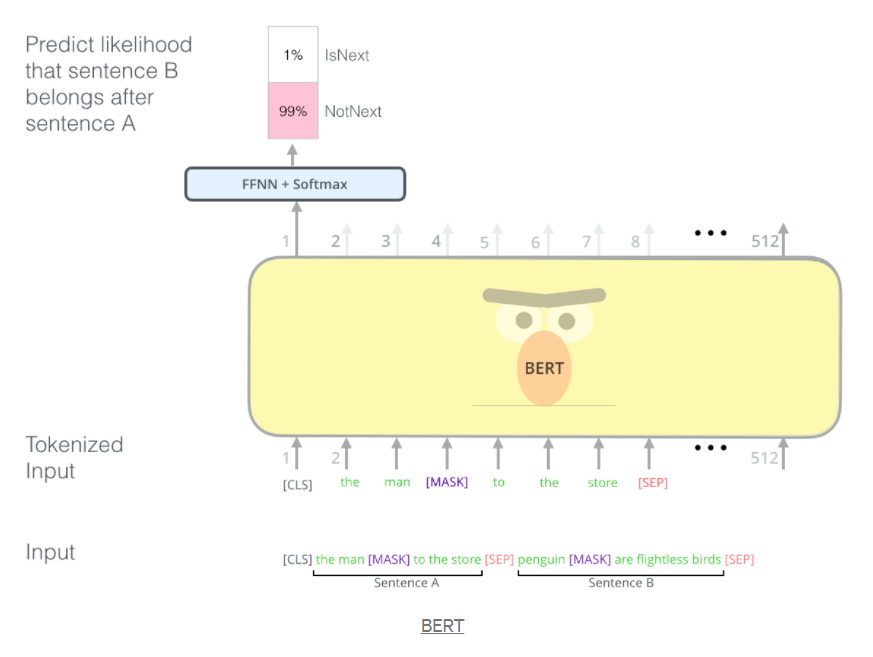

In [ ]:
!pip install transformers

In [ ]:
from transformers import TFDistilBertModel, DistilBertConfig,  DistilBertTokenizer
import tensorflow as tf 
from tensorflow.keras.models import Model
from tensorflow import keras
# from transformers import AdamW, get_linear_schedule_with_warmup
import transformers
import numpy as np
from sklearn.model_selection import train_test_split

####<font color = 'Orange'> Train-test-dev split </font>

In [ ]:
train = train_for_distilBERT.copy()

In [ ]:
#Every 5th sentence is used for validation. 
train.reset_index(drop = True,inplace=True)
dev_data = train[train.index % 10 == 0]
train_data = train[train.index % 10 != 0]

In [ ]:
#Train and test split before tokenization:
X_train, X_test, y_train, y_test = train_test_split(train_data['clean_text'], train_data.iloc[:,2:8].values, test_size=0.20, random_state=42)

####<font color = 'Orange'> Tokenization </font>

The plot below illustrates the histogram for number of words in a sentence. This visualization is useful for two downstream decisions made in our model- 

1. To fix the maximum acceptable sequence length for our encoder based classification model. 
2. To decide on whether truncation/ padding is required and how much. Also to decide whether data-collation with batch padding is necessary or not. 


Based on the plot we see that most of our data has token count less than 200. So fix our tokenizer's max length to 256. Data Collation with Batch Padding is not used because of skewed unimodal distribution of token counts

Token indices sequence length is longer than the specified maximum sequence length for this model (1072 > 512). Running this sequence through the model will result in indexing errors


Text(0, 0.5, 'Number of sentences')

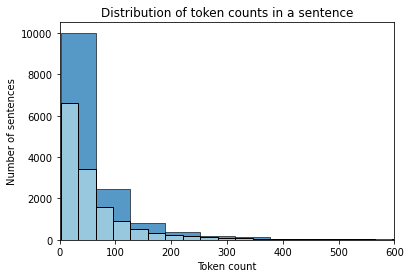

In [ ]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-cased')

sentence_length = []
#Plots for distribution of length of sentences. 
for sentence in X_train:
    token_words = tokenizer.encode_plus(sentence)['input_ids'] #For each sentence, calculate the number of tokens in each sentence. 
    sentence_length.append(len(token_words))


sns.histplot(sentence_length,bins = 50)
plt.xlim([0, 600])
plt.xlabel('Token count')
plt.ylabel('Number of sentences')

sns.histplot(sentence_length,bins = 100,color = 'Lightblue').set_title("Distribution of token counts in a sentence")
plt.xlim([0, 600])
plt.xlabel('Token count')
plt.ylabel('Number of sentences')

In [ ]:
def tokenization_data_preparation(X):
  #Apply the above tokenizer on each row of clean_text:
  X_tokens = X.apply(lambda x: tokenizer(x, return_tensors='tf', 
                                                              truncation=True,
                                                              padding='max_length',
                                                              max_length=256,
                                                              return_attention_mask = True))

  #The model accepts output as two columns - 1st column is the input and 2nd column is attention mask:
  #We feed input IDs and mask positions generated from tokenizer to the distilBERT model we will use. 
  X_input_ids= []
  X_attention_mask=[]
  for i in X_tokens:
    X_input_ids.append(i['input_ids'])
    X_attention_mask.append(i['attention_mask'])

  #Converting the shape from 1,256 into a 1-d tensor. 
  X_input_ids, X_attention_mask=np.squeeze(X_input_ids), np.squeeze(X_attention_mask)

  X_model = [X_input_ids, X_attention_mask]

  return X_model

In [ ]:
train_model_input = tokenization_data_preparation(X_train)
test_model_input = tokenization_data_preparation(X_test)
dev_model_input = tokenization_data_preparation(dev_data['clean_text'])

####<font color = 'Orange'> Sentence Embeddings using distilBERT </font>

In [ ]:
#The bare, pre-trained DistilBERT transformer model outputting raw hidden-states and without any specific head on top.
#This is used for generating sentence embeddings.

distilBERT_model = TFDistilBertModel.from_pretrained('distilbert-base-cased')

# Make DistilBERT layers untrainable for initial phases.Once the model converges this can be set to true. Currently the layers are untrainable.
for layer in distilBERT_model.layers:
  layer.trainable = False

Some layers from the model checkpoint at distilbert-base-cased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_projector', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


####<font color = 'Orange'> Keras based multi-label classification model </font>

In [ ]:
def classification_model(distilBERT_model):
  #Embedding layer for model:
  input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')
  attention_mask = tf.keras.layers.Input(shape=(256,), name='attention_mask', dtype='int32')

  embedding_layer = distilBERT_model(input_ids, attention_mask = attention_mask)
  X = embedding_layer[0][:,0,:]
  #On top of this distilBERT layer, we add additional layers as shown below
  X = tf.keras.layers.Dense(128)(X)
  X = tf.keras.layers.Dense(32)(X)
  output = tf.keras.layers.Dense(6, activation='sigmoid')(X)


  #Model optimizer:
  optimizer= tf.keras.optimizers.Adam(learning_rate=5e-5, amsgrad=False)

  #Defining model inputs and output architectures... (starting from embedding layer and desired output archicture)
  model = Model(inputs=[input_ids, attention_mask], outputs = [output])

  # compiling model 
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
  
  return model

In [ ]:
model = classification_model(distilBERT_model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  65190912   ['input_ids[0][0]',              
 BertModel)                     ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, 256, 768),                                                   
                                 hidden_states=None                                           

####<font color = 'Orange'> Model Fit and Evaluation </font>

In [ ]:
#with tf.device('/GPU:0'):
history = model.fit(train_model_input,y_train,validation_data=(dev_model_input, dev_data.iloc[:,2:8].values), batch_size=50,epochs=3,verbose=1)

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


288/288 [==============================] - 287s 980ms/step - loss: 0.3702 - accuracy: 0.8686 - val_loss: 0.2987 - val_accuracy: 0.9680
Epoch 2/3
288/288 [==============================] - 282s 980ms/step - loss: 0.2830 - accuracy: 0.9447 - val_loss: 0.2592 - val_accuracy: 0.9710
Epoch 3/3
288/288 [==============================] - 272s 943ms/step - loss: 0.2552 - accuracy: 0.9442 - val_loss: 0.2418 - val_accuracy: 0.9485


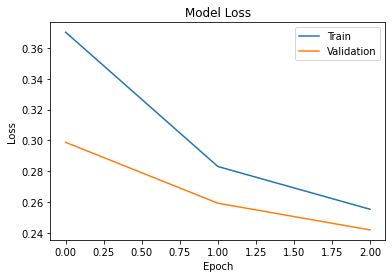

In [ ]:
#Plotting training and validation accuracies
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

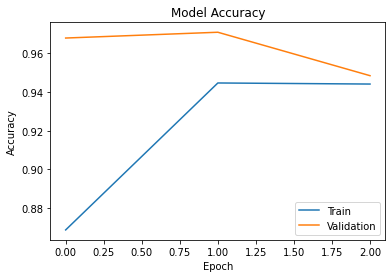

In [ ]:
#Plotting training and validation accuracies
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

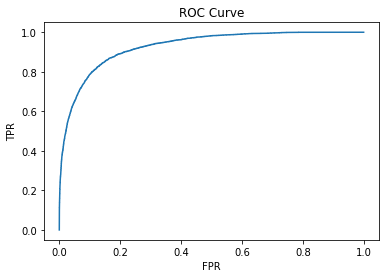

In [ ]:
preds = model.predict(test_model_input).flatten()
fpr, tpr, _ = roc_curve(y_test.flatten(), preds)
# print('Auc score for  the model is: %.2f' %(auc(fpr, tpr)*100))

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.set_title('ROC Curve')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
plt.show()
# print('Auc score for the model is: %.2f' %(auc(fpr, tpr)*100))

The plot below sets the threshold at 0.1 for assigning 0 or 1 to class label

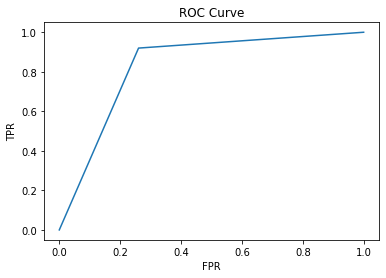

In [ ]:
binary_preds = [1 if i >= 0.1 else 0 for i in preds]
fpr, tpr, _ = roc_curve(y_test.flatten(), binary_preds)
# print('Auc score for  the model is: %.2f' %(auc(fpr, tpr)*100))

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.set_title('ROC Curve')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
plt.show()
# print('Auc score for the model is: %.2f' %(auc(fpr, tpr)*100))

##### Unflattened outputs for individual label accuracies at a threshold of 0.1 for logistic classifier.

In [ ]:
train_for_distilBERT.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_text
45045,786d8ca9b0bad3cc,"""\nI was talking about them running any check ...",1,0,0,0,0,0,I was talking about them running any check th...
27198,47f18388952e3ee7,White Trash\nFuck off you white piece of trash...,1,1,1,0,1,1,White Trash Fuck off you white piece of trash ...
16664,2bf361b9a8eb1ba5,eat shit get rid of goofs you queers.,1,0,1,0,1,0,eat shit get rid of goofs you queers
8158,15b6fd032e614001,DUMB ASSES\nIt's was my sockpuppet...joe hazet...,1,0,0,0,0,0,DUMB ASSES Its was my sockpuppetjoe hazeton yo...
142212,f8b05b9ae771fb50,"Are all professors of rhetoric pompous, self-c...",1,0,1,0,1,0,Are all professors of rhetoric pompous selfcen...


In [ ]:
preds = model.predict(test_model_input)
predictions_data = pd.DataFrame(preds,columns=['toxic', 'severe_toxic','obscene','threat','insult','identity_hate'])

binary_predictions_data = predictions_data.copy()
for column in binary_predictions_data.columns:
  binary_predictions_data[column] = binary_predictions_data[column].apply(lambda x: 1 if x > 0.1 else 0)

y_test_df = pd.DataFrame(y_test,columns=['toxic', 'severe_toxic','obscene','threat','insult','identity_hate'])


,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0.979643,0.336206,0.791758,0.027916,0.800559,0.128802
1,0.676552,0.037329,0.331240,0.018058,0.347758,0.060896
2,0.534978,0.020638,0.339646,0.013059,0.210319,0.031269
3,0.460795,0.013530,0.142359,0.015787,0.271514,0.030284
4,0.965183,0.172372,0.744293,0.045289,0.741630,0.087455


In [ ]:
accuracies= []
for label in y_test_df.columns:
  sc = accuracy_score(y_test_df[label].values, binary_predictions_data[label].values)
  accuracies.append(sc)
  print('Test accuracy for {} is {}'.format(label,sc))

Test accuracy for toxic is 0.6294444444444445
Test accuracy for severe_toxic is 0.8936111111111111
Test accuracy for obscene is 0.5963888888888889
Test accuracy for threat is 0.9875
Test accuracy for insult is 0.5994444444444444
Test accuracy for identity_hate is 0.9297222222222222


In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

doc = nlp("At tropical latitudes, the sun during noon is so warm, it can thaw ice")

for tok in doc:
  print(tok.text, tok.head, "...", tok.dep_,tok.head.dep_)

At is ... prep ccomp
tropical latitudes ... amod pobj
latitudes At ... pobj prep
, is ... punct ccomp
the sun ... det nsubj
sun is ... nsubj ccomp
during is ... prep ccomp
noon during ... pobj prep
is thaw ... ccomp ROOT
so warm ... advmod acomp
warm is ... acomp ccomp
, thaw ... punct ROOT
it thaw ... nsubj ROOT
can thaw ... aux ROOT
thaw thaw ... ROOT ROOT
ice thaw ... dobj ROOT


In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

doc = nlp("The midday sun at tropical latitudes is warm enough to thaw ice")

for tok in doc:
  print(tok.text, tok.head, "...", tok.dep_,tok.head.dep_)

The sun ... det nsubj
midday sun ... compound nsubj
sun is ... nsubj ROOT
at sun ... prep nsubj
tropical latitudes ... amod pobj
latitudes at ... pobj prep
is is ... ROOT ROOT
warm is ... acomp ROOT
enough warm ... advmod acomp
to thaw ... aux xcomp
thaw warm ... xcomp acomp
ice thaw ... dobj xcomp


In [12]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 5.0 MB/s 
     |████████████████████████████████| 596 kB 47.1 MB/s 
     |████████████████████████████████| 61 kB 492 kB/s 
     |████████████████████████████████| 3.3 MB 42.4 MB/s 
     |████████████████████████████████| 895 kB 72.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [13]:
!pip install transformer-srl

     |████████████████████████████████| 580 kB 8.2 MB/s 
     |████████████████████████████████| 402 kB 72.6 MB/s 
     |████████████████████████████████| 10.4 MB 8.9 MB/s 
     |████████████████████████████████| 12.8 MB 32.7 MB/s 
     |████████████████████████████████| 259 kB 59.5 MB/s 
     |████████████████████████████████| 776.8 MB 16 kB/s 
     |████████████████████████████████| 131 kB 71.6 MB/s 
     |████████████████████████████████| 1.8 MB 49.0 MB/s 
     |████████████████████████████████| 1.2 MB 47.4 MB/s 
     |████████████████████████████████| 124 kB 74.2 MB/s 
     |████████████████████████████████| 64 kB 2.2 MB/s 
     |████████████████████████████████| 56 kB 4.4 MB/s 
     |████████████████████████████████| 8.4 MB 24.5 MB/s 
     |████████████████████████████████| 79 kB 7.5 MB/s 
     |████████████████████████████████| 138 kB 52.3 MB/s 
     |████████████████████████████████| 127 kB 68.7 MB/s 
     |████████████████████████████████| 1.0 MB 59.5 MB/s 
     |██████████████

In [ ]:
from transformer_srl import dataset_readers, models, predictors

predictor = predictors.SrlTransformersPredictor.from_path("/usr/local/lib/python3.7/dist-packages/srl_bert_base_conll2012.tar.gz, "transformer_srl")
predictor.predict(
  sentence="Did Uriah honestly think he could beat the game in under three hours?"
)